# Assignment 4: Block Matching and Harris Corner Detection
## Ex. 4.1 Dense Optical Flow by Block Matching
* implement the block matching method as shown in the lecture
* take two frames from the datasets "lane_detection" or "racecar" with variable distances in time (1, 2, x) and compute the vector flow field
* display a subset of flow vectors on the gray-value version of the first image, by drawing a respective line. adjust the grid density such that not too many vectors overlap (**RESULT**)

In [74]:

%matplotlib inline

import matplotlib.pyplot as plt
from skimage import io, data, feature, color, filters
import numpy as np

class Match:
    def __init__(self, dif, originX, originY, targetX, targetY):
        self.dif = dif
        self.originX = originX
        self.originY = originY
        self.targetX = targetX
        self.targetY = targetY


def mse(aoi1, aoi2):
    height, width = aoi1.shape
    res = 0
    for y in range(0, height):
        for x in range(0, width):
            res += (aoi1[y, x] - aoi2[y, x])**2 
    return res


# Find first squared error within treshold and return it
# aoi to find, image to search in, search window size, origin of aoi (x and y), treshold
def matchAoi(aoi, image, ws, aoiX, aoiY, threshold):
    
    aoiHeight, aoiWidth = aoi.shape
    
    if aoiHeight == 0 or aoiWidth == 0:
        print("AOI!")
    
    halfAoiWidth = int(np.floor(aoiWidth/2))
    halfAoiHeight = int(np.floor(aoiHeight/2))
    
    height, width = image.shape

    # iterate through window
    for y in range(aoiY-ws, aoiY+ws):
        for x in range(aoiX-ws, aoiX+ws):
            
            print(x,y)
            
            minY = y - halfAoiHeight
            maxY = y + halfAoiHeight
            
            minX = x - halfAoiWidth
            maxX = x + halfAoiWidth
            
            # continue if aoi would be out of range of image
            if 0 > minY or maxY > height-1:
                continue
            
            if 0 > minX or maxX > width-1:
                continue
                
            # print(minY, maxY, minX, maxX)
            squaredError = mse(aoi, image[minY:maxY, minX:maxX])
            print(squaredError)
            
            if squaredError < threshold:
                return x, y, squaredError


# ws is the area to compare
def blockMatching(image1, image2, ws, threshold):
    height, width = image1.shape
    
    originToTarget = dict()
    
    for y in range(ws, height-ws, 20):
        for x in range(ws, width-ws, 20):
            aoi0 = image1[y-ws:y+ws, x-ws:x+ws]
            matchX, matchY, _ = matchAoi(aoi0, image2, 50, x, y, threshold)
            originToTarget[(x, y)] = (matchY, matchX)
            
            
            #print("x: {}, y: {}".format(x, y))
            
            #for dX in range(-ws,ws):
            #    for dY in range(-ws, ws):
            #        cX = x + dX
            #        cY = y + dY
            #        
            #        if (0+ws) > cX or cX > (width-ws):
            #            continue
            #        if (0+ws) > cY or cX > (height-ws):
            #            continue
            #        
            #        # print("x: {}, y: {}, dX: {}, dY: {}, cX: {}, cY: {}, ws: {}".format(x, y, dX, dY, cX,cY,ws))
            #        
            #        aoi1 = image2[cY-ws:cY+ws, cX-ws:cX+ws]
            #        dif = aoi0 - aoi1
            #        dif = np.power(dif, 2)
            #        result = np.sum(dif)
            #        
            #        if result < threshold:
            #            originToTarget[(y, x)] = (cY, cX)
                    
    return originToTarget

def drawImageWithIndicators(image, indicators):
    plt.figure(figsize=(10,15))
    plt.imshow(image)
    # for key, val in indicators:
    for key in indicators:
        val = indicators[key]
        plt.arrow(float(key[1]), float(key[0]), float(val[1]), float(val[0]), head_width=0.05, head_length=0.1, fc='k', ec='k')
    plt.show()
        
    

In [75]:
# chose other images if you like
lane1 = io.imread('images/lane_detection/f00000.png')
lane2 = io.imread('images/lane_detection/f00001.png')

car1 = io.imread('images/racecar/100.jpeg')
car2 = io.imread('images/racecar/102.jpeg') 

fig = plt.figure(0)
ax11 = plt.subplot(2, 2, 1)
ax12 = plt.subplot(2, 2, 2)
ax21 = plt.subplot(2, 2, 3)
ax22 = plt.subplot(2, 2, 4)

ax11.imshow(lane1)
ax12.imshow(lane2)

ax21.imshow(car1)
ax22.imshow(car2)

print(lane1.shape)

res = blockMatching(color.rgb2grey(lane1), color.rgb2grey(lane2), 5, 0.01)

print(len(res))

plt.figure(1)
drawImageWithIndicators(lane1, res)

plt.figure(2)
drawImageWithIndicators(lane2, res)

plt.figure(3)
plt.imshow(lane1)
plt.show()


(480, 640, 3)
-45 -45
-44 -45
-43 -45
-42 -45
-41 -45
-40 -45
-39 -45
-38 -45
-37 -45
-36 -45
-35 -45
-34 -45
-33 -45
-32 -45
-31 -45
-30 -45
-29 -45
-28 -45
-27 -45
-26 -45
-25 -45
-24 -45
-23 -45
-22 -45
-21 -45
-20 -45
-19 -45
-18 -45
-17 -45
-16 -45
-15 -45
-14 -45
-13 -45
-12 -45
-11 -45
-10 -45
-9 -45
-8 -45
-7 -45
-6 -45
-5 -45
-4 -45
-3 -45
-2 -45
-1 -45
0 -45
1 -45
2 -45
3 -45
4 -45
5 -45
6 -45
7 -45
8 -45
9 -45
10 -45
11 -45
12 -45
13 -45
14 -45
15 -45
16 -45
17 -45
18 -45
19 -45
20 -45
21 -45
22 -45
23 -45
24 -45
25 -45
26 -45
27 -45
28 -45
29 -45
30 -45
31 -45
32 -45
33 -45
34 -45
35 -45
36 -45
37 -45
38 -45
39 -45
40 -45
41 -45
42 -45
43 -45
44 -45
45 -45
46 -45
47 -45
48 -45
49 -45
50 -45
51 -45
52 -45
53 -45
54 -45
-45 -44
-44 -44
-43 -44
-42 -44
-41 -44
-40 -44
-39 -44
-38 -44
-37 -44
-36 -44
-35 -44
-34 -44
-33 -44
-32 -44
-31 -44
-30 -44
-29 -44
-28 -44
-27 -44
-26 -44
-25 -44
-24 -44
-23 -44
-22 -44
-21 -44
-20 -44
-19 -44
-18 -44
-17 -44
-16 -44
-15 -44
-14 -44
-13 

 -34
-2 -34
-1 -34
0 -34
1 -34
2 -34
3 -34
4 -34
5 -34
6 -34
7 -34
8 -34
9 -34
10 -34
11 -34
12 -34
13 -34
14 -34
15 -34
16 -34
17 -34
18 -34
19 -34
20 -34
21 -34
22 -34
23 -34
24 -34
25 -34
26 -34
27 -34
28 -34
29 -34
30 -34
31 -34
32 -34
33 -34
34 -34
35 -34
36 -34
37 -34
38 -34
39 -34
40 -34
41 -34
42 -34
43 -34
44 -34
45 -34
46 -34
47 -34
48 -34
49 -34
50 -34
51 -34
52 -34
53 -34
54 -34
-45 -33
-44 -33
-43 -33
-42 -33
-41 -33
-40 -33
-39 -33
-38 -33
-37 -33
-36 -33
-35 -33
-34 -33
-33 -33
-32 -33
-31 -33
-30 -33
-29 -33
-28 -33
-27 -33
-26 -33
-25 -33
-24 -33
-23 -33
-22 -33
-21 -33
-20 -33
-19 -33
-18 -33
-17 -33
-16 -33
-15 -33
-14 -33
-13 -33
-12 -33
-11 -33
-10 -33
-9 -33
-8 -33
-7 -33
-6 -33
-5 -33
-4 -33
-3 -33
-2 -33
-1 -33
0 -33
1 -33
2 -33
3 -33
4 -33
5 -33
6 -33
7 -33
8 -33
9 -33
10 -33
11 -33
12 -33
13 -33
14 -33
15 -33
16 -33
17 -33
18 -33
19 -33
20 -33
21 -33
22 -33
23 -33
24 -33
25 -33
26 -33
27 -33
28 -33
29 -33
30 -33
31 -33
32 -33
33 -33
34 -33
35 -33
36 -33
37 -33

-3 -24
-2 -24
-1 -24
0 -24
1 -24
2 -24
3 -24
4 -24
5 -24
6 -24
7 -24
8 -24
9 -24
10 -24
11 -24
12 -24
13 -24
14 -24
15 -24
16 -24
17 -24
18 -24
19 -24
20 -24
21 -24
22 -24
23 -24
24 -24
25 -24
26 -24
27 -24
28 -24
29 -24
30 -24
31 -24
32 -24
33 -24
34 -24
35 -24
36 -24
37 -24
38 -24
39 -24
40 -24
41 -24
42 -24
43 -24
44 -24
45 -24
46 -24
47 -24
48 -24
49 -24
50 -24
51 -24
52 -24
53 -24
54 -24
-45 -23
-44 -23
-43 -23
-42 -23
-41 -23
-40 -23
-39 -23
-38 -23
-37 -23
-36 -23
-35 -23
-34 -23
-33 -23
-32 -23
-31 -23
-30 -23
-29 -23
-28 -23
-27 -23
-26 -23
-25 -23
-24 -23
-23 -23
-22 -23
-21 -23
-20 -23
-19 -23
-18 -23
-17 -23
-16 -23
-15 -23
-14 -23
-13 -23
-12 -23
-11 -23
-10 -23
-9 -23
-8 -23
-7 -23
-6 -23
-5 -23
-4 -23
-3 -23
-2 -23
-1 -23
0 -23
1 -23
2 -23
3 -23
4 -23
5 -23
6 -23
7 -23
8 -23
9 -23
10 -23
11 -23
12 -23
13 -23
14 -23
15 -23
16 -23
17 -23
18 -23
19 -23
20 -23
21 -23
22 -23
23 -23
24 -23
25 -23
26 -23
27 -23
28 -23
29 -23
30 -23
31 -23
32 -23
33 -23
34 -23
35 -23
36 -23
37 -


-3 -14
-2 -14
-1 -14
0 -14
1 -14
2 -14
3 -14
4 -14
5 -14
6 -14
7 -14
8 -14
9 -14
10 -14
11 -14
12 -14
13 -14
14 -14
15 -14
16 -14
17 -14
18 -14
19 -14
20 -14
21 -14
22 -14
23 -14
24 -14
25 -14
26 -14
27 -14
28 -14
29 -14
30 -14
31 -14
32 -14
33 -14
34 -14
35 -14
36 -14
37 -14
38 -14
39 -14
40 -14
41 -14
42 -14
43 -14
44 -14
45 -14
46 -14
47 -14
48 -14
49 -14
50 -14
51 -14
52 -14
53 -14
54 -14
-45 -13
-44 -13
-43 -13
-42 -13
-41 -13
-40 -13
-39 -13
-38 -13
-37 -13
-36 -13
-35 -13
-34 -13
-33 -13
-32 -13
-31 -13
-30 -13
-29 -13
-28 -13
-27 -13
-26 -13
-25 -13
-24 -13
-23 -13
-22 -13
-21 -13
-20 -13
-19 -13
-18 -13
-17 -13
-16 -13
-15 -13
-14 -13
-13 -13
-12 -13
-11 -13
-10 -13
-9 -13
-8 -13
-7 -13
-6 -13
-5 -13
-4 -13
-3 -13
-2 -13
-1 -13
0 -13
1 -13
2 -13
3 -13
4 -13
5 -13
6 -13
7 -13
8 -13
9 -13
10 -13
11 -13
12 -13
13 -13
14 -13
15 -13
16 -13
17 -13
18 -13
19 -13
20 -13
21 -13
22 -13
23 -13
24 -13
25 -13
26 -13
27 -13
28 -13
29 -13
30 -13
31 -13
32 -13
33 -13
34 -13
35 -13
36 -13
37 

-4
-3 -4
-2 -4
-1 -4
0 -4
1 -4
2 -4
3 -4
4 -4
5 -4
6 -4
7 -4
8 -4
9 -4
10 -4
11 -4
12 -4
13 -4
14 -4
15 -4
16 -4
17 -4
18 -4
19 -4
20 -4
21 -4
22 -4
23 -4
24 -4
25 -4
26 -4
27 -4
28 -4
29 -4
30 -4
31 -4
32 -4
33 -4
34 -4
35 -4
36 -4
37 -4
38 -4
39 -4
40 -4
41 -4
42 -4
43 -4
44 -4
45 -4
46 -4
47 -4
48 -4
49 -4
50 -4
51 -4
52 -4
53 -4
54 -4
-45 -3
-44 -3
-43 -3
-42 -3
-41 -3
-40 -3
-39 -3
-38 -3
-37 -3
-36 -3
-35 -3
-34 -3
-33 -3
-32 -3
-31 -3
-30 -3
-29 -3
-28 -3
-27 -3
-26 -3
-25 -3
-24 -3
-23 -3
-22 -3
-21 -3
-20 -3
-19 -3
-18 -3
-17 -3
-16 -3
-15 -3
-14 -3
-13 -3
-12 -3
-11 -3
-10 -3
-9 -3
-8 -3
-7 -3
-6 -3
-5 -3
-4 -3
-3 -3
-2 -3
-1 -3
0 -3
1 -3
2 -3
3 -3
4 -3
5 -3
6 -3
7 -3
8 -3
9 -3
10 -3
11 -3
12 -3
13 -3
14 -3
15 -3
16 -3
17 -3
18 -3
19 -3
20 -3
21 -3
22 -3
23 -3
24 -3
25 -3
26 -3
27 -3
28 -3
29 -3
30 -3
31 -3
32 -3
33 -3
34 -3
35 -3
36 -3
37 -3
38 -3
39 -3
40 -3
41 -3
42 -3
43 -3
44 -3
45 -3
46 -3
47 -3
48 -3
49 -3
50 -3
51 -3
52 -3
53 -3
54 -3
-45 -2
-44 -2
-43 -2
-42 -2
-41 -


65 -45
66 -45
67 -45
68 -45
69 -45
70 -45
71 -45
72 -45
73 -45
74 -45
-25 -44
-24 -44
-23 -44
-22 -44
-21 -44
-20 -44
-19 -44
-18 -44
-17 -44
-16 -44
-15 -44
-14 -44
-13 -44
-12 -44
-11 -44
-10 -44
-9 -44
-8 -44
-7 -44
-6 -44
-5 -44
-4 -44
-3 -44
-2 -44
-1 -44
0 -44
1 -44
2 -44
3 -44
4 -44
5 -44
6 -44
7 -44
8 -44
9 -44
10 -44
11 -44
12 -44
13 -44
14 -44
15 -44
16 -44
17 -44
18 -44
19 -44
20 -44
21 -44
22 -44
23 -44
24 -44
25 -44
26 -44
27 -44
28 -44
29 -44
30 -44
31 -44
32 -44
33 -44
34 -44
35 -44
36 -44
37 -44
38 -44
39 -44
40 -44
41 -44
42 -44
43 -44
44 -44
45 -44
46 -44
47 -44
48 -44
49 -44
50 -44
51 -44
52 -44
53 -44
54 -44
55 -44
56 -44
57 -44
58 -44
59 -44
60 -44
61 -44
62 -44
63 -44
64 -44
65 -44
66 -44
67 -44
68 -44
69 -44
70 -44
71 -44
72 -44
73 -44
74 -44
-25 -43
-24 -43
-23 -43
-22 -43
-21 -43
-20 -43
-19 -43
-18 -43
-17 -43
-16 -43
-15 -43
-14 -43
-13 -43
-12 -43
-11 -43
-10 -43
-9 -43
-8 -43
-7 -43
-6 -43
-5 -43
-4 -43
-3 -43
-2 -43
-1 -43
0 -43
1 -43
2 -43
3 -43
4 -43
5 

-35
65 -35
66 -35
67 -35
68 -35
69 -35
70 -35
71 -35
72 -35
73 -35
74 -35
-25 -34
-24 -34
-23 -34
-22 -34
-21 -34
-20 -34
-19 -34
-18 -34
-17 -34
-16 -34
-15 -34
-14 -34
-13 -34
-12 -34
-11 -34
-10 -34
-9 -34
-8 -34
-7 -34
-6 -34
-5 -34
-4 -34
-3 -34
-2 -34
-1 -34
0 -34
1 -34
2 -34
3 -34
4 -34
5 -34
6 -34
7 -34
8 -34
9 -34
10 -34
11 -34
12 -34
13 -34
14 -34
15 -34
16 -34
17 -34
18 -34
19 -34
20 -34
21 -34
22 -34
23 -34
24 -34
25 -34
26 -34
27 -34
28 -34
29 -34
30 -34
31 -34
32 -34
33 -34
34 -34
35 -34
36 -34
37 -34
38 -34
39 -34
40 -34
41 -34
42 -34
43 -34
44 -34
45 -34
46 -34
47 -34
48 -34
49 -34
50 -34
51 -34
52 -34
53 -34
54 -34
55 -34
56 -34
57 -34
58 -34
59 -34
60 -34
61 -34
62 -34
63 -34
64 -34
65 -34
66 -34
67 -34
68 -34
69 -34
70 -34
71 -34
72 -34
73 -34
74 -34
-25 -33
-24 -33
-23 -33
-22 -33
-21 -33
-20 -33
-19 -33
-18 -33
-17 -33
-16 -33
-15 -33
-14 -33
-13 -33
-12 -33
-11 -33
-10 -33
-9 -33
-8 -33
-7 -33
-6 -33
-5 -33
-4 -33
-3 -33
-2 -33
-1 -33
0 -33
1 -33
2 -33
3 -33
4 -33

 -25
65 -25
66 -25
67 -25
68 -25
69 -25
70 -25
71 -25
72 -25
73 -25
74 -25
-25 -24
-24 -24
-23 -24
-22 -24
-21 -24
-20 -24
-19 -24
-18 -24
-17 -24
-16 -24
-15 -24
-14 -24
-13 -24
-12 -24
-11 -24
-10 -24
-9 -24
-8 -24
-7 -24
-6 -24
-5 -24
-4 -24
-3 -24
-2 -24
-1 -24
0 -24
1 -24
2 -24
3 -24
4 -24
5 -24
6 -24
7 -24
8 -24
9 -24
10 -24
11 -24
12 -24
13 -24
14 -24
15 -24
16 -24
17 -24
18 -24
19 -24
20 -24
21 -24
22 -24
23 -24
24 -24
25 -24
26 -24
27 -24
28 -24
29 -24
30 -24
31 -24
32 -24
33 -24
34 -24
35 -24
36 -24
37 -24
38 -24
39 -24
40 -24
41 -24
42 -24
43 -24
44 -24
45 -24
46 -24
47 -24
48 -24
49 -24
50 -24
51 -24
52 -24
53 -24
54 -24
55 -24
56 -24
57 -24
58 -24
59 -24
60 -24
61 -24
62 -24
63 -24
64 -24
65 -24
66 -24
67 -24
68 -24
69 -24
70 -24
71 -24
72 -24
73 -24
74 -24
-25 -23
-24 -23
-23 -23
-22 -23
-21 -23
-20 -23
-19 -23
-18 -23
-17 -23
-16 -23
-15 -23
-14 -23
-13 -23
-12 -23
-11 -23
-10 -23
-9 -23
-8 -23
-7 -23
-6 -23
-5 -23
-4 -23
-3 -23
-2 -23
-1 -23
0 -23
1 -23
2 -23
3 -23
4 -2

64 -15
65 -15
66 -15
67 -15
68 -15
69 -15
70 -15
71 -15
72 -15
73 -15
74 -15
-25 -14
-24 -14
-23 -14
-22 -14
-21 -14
-20 -14
-19 -14
-18 -14
-17 -14
-16 -14
-15 -14
-14 -14
-13 -14
-12 -14
-11 -14
-10 -14
-9 -14
-8 -14
-7 -14
-6 -14
-5 -14
-4 -14
-3 -14
-2 -14
-1 -14
0 -14
1 -14
2 -14
3 -14
4 -14
5 -14
6 -14
7 -14
8 -14
9 -14
10 -14
11 -14
12 -14
13 -14
14 -14
15 -14
16 -14
17 -14
18 -14
19 -14
20 -14
21 -14
22 -14
23 -14
24 -14
25 -14
26 -14
27 -14
28 -14
29 -14
30 -14
31 -14
32 -14
33 -14
34 -14
35 -14
36 -14
37 -14
38 -14
39 -14
40 -14
41 -14
42 -14
43 -14
44 -14
45 -14
46 -14
47 -14
48 -14
49 -14
50 -14
51 -14
52 -14
53 -14
54 -14
55 -14
56 -14
57 -14
58 -14
59 -14
60 -14
61 -14
62 -14
63 -14
64 -14
65 -14
66 -14
67 -14
68 -14
69 -14
70 -14
71 -14
72 -14
73 -14
74 -14
-25 -13
-24 -13
-23 -13
-22 -13
-21 -13
-20 -13
-19 -13
-18 -13
-17 -13
-16 -13
-15 -13
-14 -13
-13 -13
-12 -13
-11 -13
-10 -13
-9 -13
-8 -13
-7 -13
-6 -13
-5 -13
-4 -13
-3 -13
-2 -13
-1 -13
0 -13
1 -13
2 -13
3 -13
4 


64 -5
65 -5
66 -5
67 -5
68 -5
69 -5
70 -5
71 -5
72 -5
73 -5
74 -5
-25 -4
-24 -4
-23 -4
-22 -4
-21 -4
-20 -4
-19 -4
-18 -4
-17 -4
-16 -4
-15 -4
-14 -4
-13 -4
-12 -4
-11 -4
-10 -4
-9 -4
-8 -4
-7 -4
-6 -4
-5 -4
-4 -4
-3 -4
-2 -4
-1 -4
0 -4
1 -4
2 -4
3 -4
4 -4
5 -4
6 -4
7 -4
8 -4
9 -4
10 -4
11 -4
12 -4
13 -4
14 -4
15 -4
16 -4
17 -4
18 -4
19 -4
20 -4
21 -4
22 -4
23 -4
24 -4
25 -4
26 -4
27 -4
28 -4
29 -4
30 -4
31 -4
32 -4
33 -4
34 -4
35 -4
36 -4
37 -4
38 -4
39 -4
40 -4
41 -4
42 -4
43 -4
44 -4
45 -4
46 -4
47 -4
48 -4
49 -4
50 -4
51 -4
52 -4
53 -4
54 -4
55 -4
56 -4
57 -4
58 -4
59 -4
60 -4
61 -4
62 -4
63 -4
64 -4
65 -4
66 -4
67 -4
68 -4
69 -4
70 -4
71 -4
72 -4
73 -4
74 -4
-25 -3
-24 -3
-23 -3
-22 -3
-21 -3
-20 -3
-19 -3
-18 -3
-17 -3
-16 -3
-15 -3
-14 -3
-13 -3
-12 -3
-11 -3
-10 -3
-9 -3
-8 -3
-7 -3
-6 -3
-5 -3
-4 -3
-3 -3
-2 -3
-1 -3
0 -3
1 -3
2 -3
3 -3
4 -3
5 -3
6 -3
7 -3
8 -3
9 -3
10 -3
11 -3
12 -3
13 -3
14 -3
15 -3
16 -3
17 -3
18 -3
19 -3
20 -3
21 -3
22 -3
23 -3
24 -3
25 -3
26 -3
27 -3
28 

52 -45
53 -45
54 -45
55 -45
56 -45
57 -45
58 -45
59 -45
60 -45
61 -45
62 -45
63 -45
64 -45
65 -45
66 -45
67 -45
68 -45
69 -45
70 -45
71 -45
72 -45
73 -45
74 -45
75 -45
76 -45
77 -45
78 -45
79 -45
80 -45
81 -45
82 -45
83 -45
84 -45
85 -45
86 -45
87 -45
88 -45
89 -45
90 -45
91 -45
92 -45
93 -45
94 -45
-5 -44
-4 -44
-3 -44
-2 -44
-1 -44
0 -44
1 -44
2 -44
3 -44
4 -44
5 -44
6 -44
7 -44
8 -44
9 -44
10 -44
11 -44
12 -44
13 -44
14 -44
15 -44
16 -44
17 -44
18 -44
19 -44
20 -44
21 -44
22 -44
23 -44
24 -44
25 -44
26 -44
27 -44
28 -44
29 -44
30 -44
31 -44
32 -44
33 -44
34 -44
35 -44
36 -44
37 -44
38 -44
39 -44
40 -44
41 -44
42 -44
43 -44
44 -44
45 -44
46 -44
47 -44
48 -44
49 -44
50 -44
51 -44
52 -44
53 -44
54 -44
55 -44
56 -44
57 -44
58 -44
59 -44
60 -44
61 -44
62 -44
63 -44
64 -44
65 -44
66 -44
67 -44
68 -44
69 -44
70 -44
71 -44
72 -44
73 -44
74 -44
75 -44
76 -44
77 -44
78 -44
79 -44
80 -44
81 -44
82 -44
83 -44
84 -44
85 -44
86 -44
87 -44
88 -44
89 -44
90 -44
91 -44
92 -44
93 -44
94 -44
-5 -43
-4


52 -35
53 -35
54 -35
55 -35
56 -35
57 -35
58 -35
59 -35
60 -35
61 -35
62 -35
63 -35
64 -35
65 -35
66 -35
67 -35
68 -35
69 -35
70 -35
71 -35
72 -35
73 -35
74 -35
75 -35
76 -35
77 -35
78 -35
79 -35
80 -35
81 -35
82 -35
83 -35
84 -35
85 -35
86 -35
87 -35
88 -35
89 -35
90 -35
91 -35
92 -35
93 -35
94 -35
-5 -34
-4 -34
-3 -34
-2 -34
-1 -34
0 -34
1 -34
2 -34
3 -34
4 -34
5 -34
6 -34
7 -34
8 -34
9 -34
10 -34
11 -34
12 -34
13 -34
14 -34
15 -34
16 -34
17 -34
18 -34
19 -34
20 -34
21 -34
22 -34
23 -34
24 -34
25 -34
26 -34
27 -34
28 -34
29 -34
30 -34
31 -34
32 -34
33 -34
34 -34
35 -34
36 -34
37 -34
38 -34
39 -34
40 -34
41 -34
42 -34
43 -34
44 -34
45 -34
46 -34
47 -34
48 -34
49 -34
50 -34
51 -34
52 -34
53 -34
54 -34
55 -34
56 -34
57 -34
58 -34
59 -34
60 -34
61 -34
62 -34
63 -34
64 -34
65 -34
66 -34
67 -34
68 -34
69 -34
70 -34
71 -34
72 -34
73 -34
74 -34
75 -34
76 -34
77 -34
78 -34
79 -34
80 -34
81 -34
82 -34
83 -34
84 -34
85 -34
86 -34
87 -34
88 -34
89 -34
90 -34
91 -34
92 -34
93 -34
94 -34
-5 -33
-

-25
52 -25
53 -25
54 -25
55 -25
56 -25
57 -25
58 -25
59 -25
60 -25
61 -25
62 -25
63 -25
64 -25
65 -25
66 -25
67 -25
68 -25
69 -25
70 -25
71 -25
72 -25
73 -25
74 -25
75 -25
76 -25
77 -25
78 -25
79 -25
80 -25
81 -25
82 -25
83 -25
84 -25
85 -25
86 -25
87 -25
88 -25
89 -25
90 -25
91 -25
92 -25
93 -25
94 -25
-5 -24
-4 -24
-3 -24
-2 -24
-1 -24
0 -24
1 -24
2 -24
3 -24
4 -24
5 -24
6 -24
7 -24
8 -24
9 -24
10 -24
11 -24
12 -24
13 -24
14 -24
15 -24
16 -24
17 -24
18 -24
19 -24
20 -24
21 -24
22 -24
23 -24
24 -24
25 -24
26 -24
27 -24
28 -24
29 -24
30 -24
31 -24
32 -24
33 -24
34 -24
35 -24
36 -24
37 -24
38 -24
39 -24
40 -24
41 -24
42 -24
43 -24
44 -24
45 -24
46 -24
47 -24
48 -24
49 -24
50 -24
51 -24
52 -24
53 -24
54 -24
55 -24
56 -24
57 -24
58 -24
59 -24
60 -24
61 -24
62 -24
63 -24
64 -24
65 -24
66 -24
67 -24
68 -24
69 -24
70 -24
71 -24
72 -24
73 -24
74 -24
75 -24
76 -24
77 -24
78 -24
79 -24
80 -24
81 -24
82 -24
83 -24
84 -24
85 -24
86 -24
87 -24
88 -24
89 -24
90 -24
91 -24
92 -24
93 -24
94 -24
-5 -2

 -15
52 -15
53 -15
54 -15
55 -15
56 -15
57 -15
58 -15
59 -15
60 -15
61 -15
62 -15
63 -15
64 -15
65 -15
66 -15
67 -15
68 -15
69 -15
70 -15
71 -15
72 -15
73 -15
74 -15
75 -15
76 -15
77 -15
78 -15
79 -15
80 -15
81 -15
82 -15
83 -15
84 -15
85 -15
86 -15
87 -15
88 -15
89 -15
90 -15
91 -15
92 -15
93 -15
94 -15
-5 -14
-4 -14
-3 -14
-2 -14
-1 -14
0 -14
1 -14
2 -14
3 -14
4 -14
5 -14
6 -14
7 -14
8 -14
9 -14
10 -14
11 -14
12 -14
13 -14
14 -14
15 -14
16 -14
17 -14
18 -14
19 -14
20 -14
21 -14
22 -14
23 -14
24 -14
25 -14
26 -14
27 -14
28 -14
29 -14
30 -14
31 -14
32 -14
33 -14
34 -14
35 -14
36 -14
37 -14
38 -14
39 -14
40 -14
41 -14
42 -14
43 -14
44 -14
45 -14
46 -14
47 -14
48 -14
49 -14
50 -14
51 -14
52 -14
53 -14
54 -14
55 -14
56 -14
57 -14
58 -14
59 -14
60 -14
61 -14
62 -14
63 -14
64 -14
65 -14
66 -14
67 -14
68 -14
69 -14
70 -14
71 -14
72 -14
73 -14
74 -14
75 -14
76 -14
77 -14
78 -14
79 -14
80 -14
81 -14
82 -14
83 -14
84 -14
85 -14
86 -14
87 -14
88 -14
89 -14
90 -14
91 -14
92 -14
93 -14
94 -14
-5 -

1 -7
2 -7
3 -7
4 -7
5 -7
6 -7
7 -7
8 -7
9 -7
10 -7
11 -7
12 -7
13 -7
14 -7
15 -7
16 -7
17 -7
18 -7
19 -7
20 -7
21 -7
22 -7
23 -7
24 -7
25 -7
26 -7
27 -7
28 -7
29 -7
30 -7
31 -7
32 -7
33 -7
34 -7
35 -7
36 -7
37 -7
38 -7
39 -7
40 -7
41 -7
42 -7
43 -7
44 -7
45 -7
46 -7
47 -7
48 -7
49 -7
50 -7
51 -7
52 -7
53 -7
54 -7
55 -7
56 -7
57 -7
58 -7
59 -7
60 -7
61 -7
62 -7
63 -7
64 -7
65 -7
66 -7
67 -7
68 -7
69 -7
70 -7
71 -7
72 -7
73 -7
74 -7
75 -7
76 -7
77 -7
78 -7
79 -7
80 -7
81 -7
82 -7
83 -7
84 -7
85 -7
86 -7
87 -7
88 -7
89 -7
90 -7
91 -7
92 -7
93 -7
94 -7
-5 -6
-4 -6
-3 -6
-2 -6
-1 -6
0 -6
1 -6
2 -6
3 -6
4 -6
5 -6
6 -6
7 -6
8 -6
9 -6
10 -6
11 -6
12 -6
13 -6
14 -6
15 -6
16 -6
17 -6
18 -6
19 -6
20 -6
21 -6
22 -6
23 -6
24 -6
25 -6
26 -6
27 -6
28 -6
29 -6
30 -6
31 -6
32 -6
33 -6
34 -6
35 -6
36 -6
37 -6
38 -6
39 -6
40 -6
41 -6
42 -6
43 -6
44 -6
45 -6
46 -6
47 -6
48 -6
49 -6
50 -6
51 -6
52 -6
53 -6
54 -6
55 -6
56 -6
57 -6
58 -6
59 -6
60 -6
61 -6
62 -6
63 -6
64 -6
65 -6
66 -6
67 -6
68 -6
69 -6
70 -6


1 3
2 3
3 3
4 3
5 3
6 3
7 3
8 3
9 3
10 3
11 3
12 3
13 3
14 3
15 3
16 3
17 3
18 3
19 3
20 3
21 3
22 3
23 3
24 3
25 3
26 3
27 3
28 3
29 3
30 3
31 3
32 3
33 3
34 3
35 3
36 3
37 3
38 3
39 3
40 3
41 3
42 3
43 3
44 3
45 3
46 3
47 3
48 3
49 3
50 3
51 3
52 3
53 3
54 3
55 3
56 3
57 3
58 3
59 3
60 3
61 3
62 3
63 3
64 3
65 3
66 3
67 3
68 3
69 3
70 3
71 3
72 3
73 3
74 3
75 3
76 3
77 3
78 3
79 3
80 3
81 3
82 3
83 3
84 3
85 3
86 3
87 3
88 3
89 3
90 3
91 3
92 3
93 3
94 3
-5 4
-4 4
-3 4
-2 4
-1 4
0 4
1 4
2 4
3 4
4 4
5 4
6 4
7 4
8 4
9 4
10 4
11 4
12 4
13 4
14 4
15 4
16 4
17 4
18 4
19 4
20 4
21 4
22 4
23 4
24 4
25 4
26 4
27 4
28 4
29 4
30 4
31 4
32 4
33 4
34 4
35 4
36 4
37 4
38 4
39 4
40 4
41 4
42 4
43 4
44 4
45 4
46 4
47 4
48 4
49 4
50 4
51 4
52 4
53 4
54 4
55 4
56 4
57 4
58 4
59 4
60 4
61 4
62 4
63 4
64 4
65 4
66 4
67 4
68 4
69 4
70 4
71 4
72 4
73 4
74 4
75 4
76 4
77 4
78 4
79 4
80 4
81 4
82 4
83 4
84 4
85 4
86 4
87 4
88 4
89 4
90 4
91 4
92 4
93 4
94 4
-5 5
-4 5
-3 5
-2 5
-1 5
0 5
1 5
2 5
3 5
4 5
5 5

-38
90 -38
91 -38
92 -38
93 -38
94 -38
95 -38
96 -38
97 -38
98 -38
99 -38
100 -38
101 -38
102 -38
103 -38
104 -38
105 -38
106 -38
107 -38
108 -38
109 -38
110 -38
111 -38
112 -38
113 -38
114 -38
15 -37
16 -37
17 -37
18 -37
19 -37
20 -37
21 -37
22 -37
23 -37
24 -37
25 -37
26 -37
27 -37
28 -37
29 -37
30 -37
31 -37
32 -37
33 -37
34 -37
35 -37
36 -37
37 -37
38 -37
39 -37
40 -37
41 -37
42 -37
43 -37
44 -37
45 -37
46 -37
47 -37
48 -37
49 -37
50 -37
51 -37
52 -37
53 -37
54 -37
55 -37
56 -37
57 -37
58 -37
59 -37
60 -37
61 -37
62 -37
63 -37
64 -37
65 -37
66 -37
67 -37
68 -37
69 -37
70 -37
71 -37
72 -37
73 -37
74 -37
75 -37
76 -37
77 -37
78 -37
79 -37
80 -37
81 -37
82 -37
83 -37
84 -37
85 -37
86 -37
87 -37
88 -37
89 -37
90 -37
91 -37
92 -37
93 -37
94 -37
95 -37
96 -37
97 -37
98 -37
99 -37
100 -37
101 -37
102 -37
103 -37
104 -37
105 -37
106 -37
107 -37
108 -37
109 -37
110 -37
111 -37
112 -37
113 -37
114 -37
15 -36
16 -36
17 -36
18 -36
19 -36
20 -36
21 -36
22 -36
23 -36
24 -36
25 -36
26 -36
27 -36


 -28
90 -28
91 -28
92 -28
93 -28
94 -28
95 -28
96 -28
97 -28
98 -28
99 -28
100 -28
101 -28
102 -28
103 -28
104 -28
105 -28
106 -28
107 -28
108 -28
109 -28
110 -28
111 -28
112 -28
113 -28
114 -28
15 -27
16 -27
17 -27
18 -27
19 -27
20 -27
21 -27
22 -27
23 -27
24 -27
25 -27
26 -27
27 -27
28 -27
29 -27
30 -27
31 -27
32 -27
33 -27
34 -27
35 -27
36 -27
37 -27
38 -27
39 -27
40 -27
41 -27
42 -27
43 -27
44 -27
45 -27
46 -27
47 -27
48 -27
49 -27
50 -27
51 -27
52 -27
53 -27
54 -27
55 -27
56 -27
57 -27
58 -27
59 -27
60 -27
61 -27
62 -27
63 -27
64 -27
65 -27
66 -27
67 -27
68 -27
69 -27
70 -27
71 -27
72 -27
73 -27
74 -27
75 -27
76 -27
77 -27
78 -27
79 -27
80 -27
81 -27
82 -27
83 -27
84 -27
85 -27
86 -27
87 -27
88 -27
89 -27
90 -27
91 -27
92 -27
93 -27
94 -27
95 -27
96 -27
97 -27
98 -27
99 -27
100 -27
101 -27
102 -27
103 -27
104 -27
105 -27
106 -27
107 -27
108 -27
109 -27
110 -27
111 -27
112 -27
113 -27
114 -27
15 -26
16 -26
17 -26
18 -26
19 -26
20 -26
21 -26
22 -26
23 -26
24 -26
25 -26
26 -26
27 -26

89 -18
90 -18
91 -18
92 -18
93 -18
94 -18
95 -18
96 -18
97 -18
98 -18
99 -18
100 -18
101 -18
102 -18
103 -18
104 -18
105 -18
106 -18
107 -18
108 -18
109 -18
110 -18
111 -18
112 -18
113 -18
114 -18
15 -17
16 -17
17 -17
18 -17
19 -17
20 -17
21 -17
22 -17
23 -17
24 -17
25 -17
26 -17
27 -17
28 -17
29 -17
30 -17
31 -17
32 -17
33 -17
34 -17
35 -17
36 -17
37 -17
38 -17
39 -17
40 -17
41 -17
42 -17
43 -17
44 -17
45 -17
46 -17
47 -17
48 -17
49 -17
50 -17
51 -17
52 -17
53 -17
54 -17
55 -17
56 -17
57 -17
58 -17
59 -17
60 -17
61 -17
62 -17
63 -17
64 -17
65 -17
66 -17
67 -17
68 -17
69 -17
70 -17
71 -17
72 -17
73 -17
74 -17
75 -17
76 -17
77 -17
78 -17
79 -17
80 -17
81 -17
82 -17
83 -17
84 -17
85 -17
86 -17
87 -17
88 -17
89 -17
90 -17
91 -17
92 -17
93 -17
94 -17
95 -17
96 -17
97 -17
98 -17
99 -17
100 -17
101 -17
102 -17
103 -17
104 -17
105 -17
106 -17
107 -17
108 -17
109 -17
110 -17
111 -17
112 -17
113 -17
114 -17
15 -16
16 -16
17 -16
18 -16
19 -16
20 -16
21 -16
22 -16
23 -16
24 -16
25 -16
26 -16
27 -


89 -8
90 -8
91 -8
92 -8
93 -8
94 -8
95 -8
96 -8
97 -8
98 -8
99 -8
100 -8
101 -8
102 -8
103 -8
104 -8
105 -8
106 -8
107 -8
108 -8
109 -8
110 -8
111 -8
112 -8
113 -8
114 -8
15 -7
16 -7
17 -7
18 -7
19 -7
20 -7
21 -7
22 -7
23 -7
24 -7
25 -7
26 -7
27 -7
28 -7
29 -7
30 -7
31 -7
32 -7
33 -7
34 -7
35 -7
36 -7
37 -7
38 -7
39 -7
40 -7
41 -7
42 -7
43 -7
44 -7
45 -7
46 -7
47 -7
48 -7
49 -7
50 -7
51 -7
52 -7
53 -7
54 -7
55 -7
56 -7
57 -7
58 -7
59 -7
60 -7
61 -7
62 -7
63 -7
64 -7
65 -7
66 -7
67 -7
68 -7
69 -7
70 -7
71 -7
72 -7
73 -7
74 -7
75 -7
76 -7
77 -7
78 -7
79 -7
80 -7
81 -7
82 -7
83 -7
84 -7
85 -7
86 -7
87 -7
88 -7
89 -7
90 -7
91 -7
92 -7
93 -7
94 -7
95 -7
96 -7
97 -7
98 -7
99 -7
100 -7
101 -7
102 -7
103 -7
104 -7
105 -7
106 -7
107 -7
108 -7
109 -7
110 -7
111 -7
112 -7
113 -7
114 -7
15 -6
16 -6
17 -6
18 -6
19 -6
20 -6
21 -6
22 -6
23 -6
24 -6
25 -6
26 -6
27 -6
28 -6
29 -6
30 -6
31 -6
32 -6
33 -6
34 -6
35 -6
36 -6
37 -6
38 -6
39 -6
40 -6
41 -6
42 -6
43 -6
44 -6
45 -6
46 -6
47 -6
48 -6
49 -6
50 

2
89 2
90 2
91 2
92 2
93 2
94 2
95 2
96 2
97 2
98 2
99 2
100 2
101 2
102 2
103 2
104 2
105 2
106 2
107 2
108 2
109 2
110 2
111 2
112 2
113 2
114 2
15 3
16 3
17 3
18 3
19 3
20 3
21 3
22 3
23 3
24 3
25 3
26 3
27 3
28 3
29 3
30 3
31 3
32 3
33 3
34 3
35 3
36 3
37 3
38 3
39 3
40 3
41 3
42 3
43 3
44 3
45 3
46 3
47 3
48 3
49 3
50 3
51 3
52 3
53 3
54 3
55 3
56 3
57 3
58 3
59 3
60 3
61 3
62 3
63 3
64 3
65 3
66 3
67 3
68 3
69 3
70 3
71 3
72 3
73 3
74 3
75 3
76 3
77 3
78 3
79 3
80 3
81 3
82 3
83 3
84 3
85 3
86 3
87 3
88 3
89 3
90 3
91 3
92 3
93 3
94 3
95 3
96 3
97 3
98 3
99 3
100 3
101 3
102 3
103 3
104 3
105 3
106 3
107 3
108 3
109 3
110 3
111 3
112 3
113 3
114 3
15 4
16 4
17 4
18 4
19 4
20 4
21 4
22 4
23 4
24 4
25 4
26 4
27 4
28 4
29 4
30 4
31 4
32 4
33 4
34 4
35 4
36 4
37 4
38 4
39 4
40 4
41 4
42 4
43 4
44 4
45 4
46 4
47 4
48 4
49 4
50 4
51 4
52 4
53 4
54 4
55 4
56 4
57 4
58 4
59 4
60 4
61 4
62 4
63 4
64 4
65 4
66 4
67 4
68 4
69 4
70 4
71 4
72 4
73 4
74 4
75 4
76 4
77 4
78 4
79 4
80 4
81 4
82 


95 -38
96 -38
97 -38
98 -38
99 -38
100 -38
101 -38
102 -38
103 -38
104 -38
105 -38
106 -38
107 -38
108 -38
109 -38
110 -38
111 -38
112 -38
113 -38
114 -38
115 -38
116 -38
117 -38
118 -38
119 -38
120 -38
121 -38
122 -38
123 -38
124 -38
125 -38
126 -38
127 -38
128 -38
129 -38
130 -38
131 -38
132 -38
133 -38
134 -38
35 -37
36 -37
37 -37
38 -37
39 -37
40 -37
41 -37
42 -37
43 -37
44 -37
45 -37
46 -37
47 -37
48 -37
49 -37
50 -37
51 -37
52 -37
53 -37
54 -37
55 -37
56 -37
57 -37
58 -37
59 -37
60 -37
61 -37
62 -37
63 -37
64 -37
65 -37
66 -37
67 -37
68 -37
69 -37
70 -37
71 -37
72 -37
73 -37
74 -37
75 -37
76 -37
77 -37
78 -37
79 -37
80 -37
81 -37
82 -37
83 -37
84 -37
85 -37
86 -37
87 -37
88 -37
89 -37
90 -37
91 -37
92 -37
93 -37
94 -37
95 -37
96 -37
97 -37
98 -37
99 -37
100 -37
101 -37
102 -37
103 -37
104 -37
105 -37
106 -37
107 -37
108 -37
109 -37
110 -37
111 -37
112 -37
113 -37
114 -37
115 -37
116 -37
117 -37
118 -37
119 -37
120 -37
121 -37
122 -37
123 -37
124 -37
125 -37
126 -37
127 -37
128 -

-28
95 -28
96 -28
97 -28
98 -28
99 -28
100 -28
101 -28
102 -28
103 -28
104 -28
105 -28
106 -28
107 -28
108 -28
109 -28
110 -28
111 -28
112 -28
113 -28
114 -28
115 -28
116 -28
117 -28
118 -28
119 -28
120 -28
121 -28
122 -28
123 -28
124 -28
125 -28
126 -28
127 -28
128 -28
129 -28
130 -28
131 -28
132 -28
133 -28
134 -28
35 -27
36 -27
37 -27
38 -27
39 -27
40 -27
41 -27
42 -27
43 -27
44 -27
45 -27
46 -27
47 -27
48 -27
49 -27
50 -27
51 -27
52 -27
53 -27
54 -27
55 -27
56 -27
57 -27
58 -27
59 -27
60 -27
61 -27
62 -27
63 -27
64 -27
65 -27
66 -27
67 -27
68 -27
69 -27
70 -27
71 -27
72 -27
73 -27
74 -27
75 -27
76 -27
77 -27
78 -27
79 -27
80 -27
81 -27
82 -27
83 -27
84 -27
85 -27
86 -27
87 -27
88 -27
89 -27
90 -27
91 -27
92 -27
93 -27
94 -27
95 -27
96 -27
97 -27
98 -27
99 -27
100 -27
101 -27
102 -27
103 -27
104 -27
105 -27
106 -27
107 -27
108 -27
109 -27
110 -27
111 -27
112 -27
113 -27
114 -27
115 -27
116 -27
117 -27
118 -27
119 -27
120 -27
121 -27
122 -27
123 -27
124 -27
125 -27
126 -27
127 -27
12

 -18
95 -18
96 -18
97 -18
98 -18
99 -18
100 -18
101 -18
102 -18
103 -18
104 -18
105 -18
106 -18
107 -18
108 -18
109 -18
110 -18
111 -18
112 -18
113 -18
114 -18
115 -18
116 -18
117 -18
118 -18
119 -18
120 -18
121 -18
122 -18
123 -18
124 -18
125 -18
126 -18
127 -18
128 -18
129 -18
130 -18
131 -18
132 -18
133 -18
134 -18
35 -17
36 -17
37 -17
38 -17
39 -17
40 -17
41 -17
42 -17
43 -17
44 -17
45 -17
46 -17
47 -17
48 -17
49 -17
50 -17
51 -17
52 -17
53 -17
54 -17
55 -17
56 -17
57 -17
58 -17
59 -17
60 -17
61 -17
62 -17
63 -17
64 -17
65 -17
66 -17
67 -17
68 -17
69 -17
70 -17
71 -17
72 -17
73 -17
74 -17
75 -17
76 -17
77 -17
78 -17
79 -17
80 -17
81 -17
82 -17
83 -17
84 -17
85 -17
86 -17
87 -17
88 -17
89 -17
90 -17
91 -17
92 -17
93 -17
94 -17
95 -17
96 -17
97 -17
98 -17
99 -17
100 -17
101 -17
102 -17
103 -17
104 -17
105 -17
106 -17
107 -17
108 -17
109 -17
110 -17
111 -17
112 -17
113 -17
114 -17
115 -17
116 -17
117 -17
118 -17
119 -17
120 -17
121 -17
122 -17
123 -17
124 -17
125 -17
126 -17
127 -17
1

94 -8
95 -8
96 -8
97 -8
98 -8
99 -8
100 -8
101 -8
102 -8
103 -8
104 -8
105 -8
106 -8
107 -8
108 -8
109 -8
110 -8
111 -8
112 -8
113 -8
114 -8
115 -8
116 -8
117 -8
118 -8
119 -8
120 -8
121 -8
122 -8
123 -8
124 -8
125 -8
126 -8
127 -8
128 -8
129 -8
130 -8
131 -8
132 -8
133 -8
134 -8
35 -7
36 -7
37 -7
38 -7
39 -7
40 -7
41 -7
42 -7
43 -7
44 -7
45 -7
46 -7
47 -7
48 -7
49 -7
50 -7
51 -7
52 -7
53 -7
54 -7
55 -7
56 -7
57 -7
58 -7
59 -7
60 -7
61 -7
62 -7
63 -7
64 -7
65 -7
66 -7
67 -7
68 -7
69 -7
70 -7
71 -7
72 -7
73 -7
74 -7
75 -7
76 -7
77 -7
78 -7
79 -7
80 -7
81 -7
82 -7
83 -7
84 -7
85 -7
86 -7
87 -7
88 -7
89 -7
90 -7
91 -7
92 -7
93 -7
94 -7
95 -7
96 -7
97 -7
98 -7
99 -7
100 -7
101 -7
102 -7
103 -7
104 -7
105 -7
106 -7
107 -7
108 -7
109 -7
110 -7
111 -7
112 -7
113 -7
114 -7
115 -7
116 -7
117 -7
118 -7
119 -7
120 -7
121 -7
122 -7
123 -7
124 -7
125 -7
126 -7
127 -7
128 -7
129 -7
130 -7
131 -7
132 -7
133 -7
134 -7
35 -6
36 -6
37 -6
38 -6
39 -6
40 -6
41 -6
42 -6
43 -6
44 -6
45 -6
46 -6
47 -6
48 -6



94 2
95 2
96 2
97 2
98 2
99 2
100 2
101 2
102 2
103 2
104 2
105 2
106 2
107 2
108 2
109 2
110 2
111 2
112 2
113 2
114 2
115 2
116 2
117 2
118 2
119 2
120 2
121 2
122 2
123 2
124 2
125 2
126 2
127 2
128 2
129 2
130 2
131 2
132 2
133 2
134 2
35 3
36 3
37 3
38 3
39 3
40 3
41 3
42 3
43 3
44 3
45 3
46 3
47 3
48 3
49 3
50 3
51 3
52 3
53 3
54 3
55 3
56 3
57 3
58 3
59 3
60 3
61 3
62 3
63 3
64 3
65 3
66 3
67 3
68 3
69 3
70 3
71 3
72 3
73 3
74 3
75 3
76 3
77 3
78 3
79 3
80 3
81 3
82 3
83 3
84 3
85 3
86 3
87 3
88 3
89 3
90 3
91 3
92 3
93 3
94 3
95 3
96 3
97 3
98 3
99 3
100 3
101 3
102 3
103 3
104 3
105 3
106 3
107 3
108 3
109 3
110 3
111 3
112 3
113 3
114 3
115 3
116 3
117 3
118 3
119 3
120 3
121 3
122 3
123 3
124 3
125 3
126 3
127 3
128 3
129 3
130 3
131 3
132 3
133 3
134 3
35 4
36 4
37 4
38 4
39 4
40 4
41 4
42 4
43 4
44 4
45 4
46 4
47 4
48 4
49 4
50 4
51 4
52 4
53 4
54 4
55 4
56 4
57 4
58 4
59 4
60 4
61 4
62 4
63 4
64 4
65 4
66 4
67 4
68 4
69 4
70 4
71 4
72 4
73 4
74 4
75 4
76 4
77 4
78 4
79 4

-38
105 -38
106 -38
107 -38
108 -38
109 -38
110 -38
111 -38
112 -38
113 -38
114 -38
115 -38
116 -38
117 -38
118 -38
119 -38
120 -38
121 -38
122 -38
123 -38
124 -38
125 -38
126 -38
127 -38
128 -38
129 -38
130 -38
131 -38
132 -38
133 -38
134 -38
135 -38
136 -38
137 -38
138 -38
139 -38
140 -38
141 -38
142 -38
143 -38
144 -38
145 -38
146 -38
147 -38
148 -38
149 -38
150 -38
151 -38
152 -38
153 -38
154 -38
55 -37
56 -37
57 -37
58 -37
59 -37
60 -37
61 -37
62 -37
63 -37
64 -37
65 -37
66 -37
67 -37
68 -37
69 -37
70 -37
71 -37
72 -37
73 -37
74 -37
75 -37
76 -37
77 -37
78 -37
79 -37
80 -37
81 -37
82 -37
83 -37
84 -37
85 -37
86 -37
87 -37
88 -37
89 -37
90 -37
91 -37
92 -37
93 -37
94 -37
95 -37
96 -37
97 -37
98 -37
99 -37
100 -37
101 -37
102 -37
103 -37
104 -37
105 -37
106 -37
107 -37
108 -37
109 -37
110 -37
111 -37
112 -37
113 -37
114 -37
115 -37
116 -37
117 -37
118 -37
119 -37
120 -37
121 -37
122 -37
123 -37
124 -37
125 -37
126 -37
127 -37
128 -37
129 -37
130 -37
131 -37
132 -37
133 -37
134 -37
1

 -28
105 -28
106 -28
107 -28
108 -28
109 -28
110 -28
111 -28
112 -28
113 -28
114 -28
115 -28
116 -28
117 -28
118 -28
119 -28
120 -28
121 -28
122 -28
123 -28
124 -28
125 -28
126 -28
127 -28
128 -28
129 -28
130 -28
131 -28
132 -28
133 -28
134 -28
135 -28
136 -28
137 -28
138 -28
139 -28
140 -28
141 -28
142 -28
143 -28
144 -28
145 -28
146 -28
147 -28
148 -28
149 -28
150 -28
151 -28
152 -28
153 -28
154 -28
55 -27
56 -27
57 -27
58 -27
59 -27
60 -27
61 -27
62 -27
63 -27
64 -27
65 -27
66 -27
67 -27
68 -27
69 -27
70 -27
71 -27
72 -27
73 -27
74 -27
75 -27
76 -27
77 -27
78 -27
79 -27
80 -27
81 -27
82 -27
83 -27
84 -27
85 -27
86 -27
87 -27
88 -27
89 -27
90 -27
91 -27
92 -27
93 -27
94 -27
95 -27
96 -27
97 -27
98 -27
99 -27
100 -27
101 -27
102 -27
103 -27
104 -27
105 -27
106 -27
107 -27
108 -27
109 -27
110 -27
111 -27
112 -27
113 -27
114 -27
115 -27
116 -27
117 -27
118 -27
119 -27
120 -27
121 -27
122 -27
123 -27
124 -27
125 -27
126 -27
127 -27
128 -27
129 -27
130 -27
131 -27
132 -27
133 -27
134 -27


104 -18
105 -18
106 -18
107 -18
108 -18
109 -18
110 -18
111 -18
112 -18
113 -18
114 -18
115 -18
116 -18
117 -18
118 -18
119 -18
120 -18
121 -18
122 -18
123 -18
124 -18
125 -18
126 -18
127 -18
128 -18
129 -18
130 -18
131 -18
132 -18
133 -18
134 -18
135 -18
136 -18
137 -18
138 -18
139 -18
140 -18
141 -18
142 -18
143 -18
144 -18
145 -18
146 -18
147 -18
148 -18
149 -18
150 -18
151 -18
152 -18
153 -18
154 -18
55 -17
56 -17
57 -17
58 -17
59 -17
60 -17
61 -17
62 -17
63 -17
64 -17
65 -17
66 -17
67 -17
68 -17
69 -17
70 -17
71 -17
72 -17
73 -17
74 -17
75 -17
76 -17
77 -17
78 -17
79 -17
80 -17
81 -17
82 -17
83 -17
84 -17
85 -17
86 -17
87 -17
88 -17
89 -17
90 -17
91 -17
92 -17
93 -17
94 -17
95 -17
96 -17
97 -17
98 -17
99 -17
100 -17
101 -17
102 -17
103 -17
104 -17
105 -17
106 -17
107 -17
108 -17
109 -17
110 -17
111 -17
112 -17
113 -17
114 -17
115 -17
116 -17
117 -17
118 -17
119 -17
120 -17
121 -17
122 -17
123 -17
124 -17
125 -17
126 -17
127 -17
128 -17
129 -17
130 -17
131 -17
132 -17
133 -17
134 -


104 -8
105 -8
106 -8
107 -8
108 -8
109 -8
110 -8
111 -8
112 -8
113 -8
114 -8
115 -8
116 -8
117 -8
118 -8
119 -8
120 -8
121 -8
122 -8
123 -8
124 -8
125 -8
126 -8
127 -8
128 -8
129 -8
130 -8
131 -8
132 -8
133 -8
134 -8
135 -8
136 -8
137 -8
138 -8
139 -8
140 -8
141 -8
142 -8
143 -8
144 -8
145 -8
146 -8
147 -8
148 -8
149 -8
150 -8
151 -8
152 -8
153 -8
154 -8
55 -7
56 -7
57 -7
58 -7
59 -7
60 -7
61 -7
62 -7
63 -7
64 -7
65 -7
66 -7
67 -7
68 -7
69 -7
70 -7
71 -7
72 -7
73 -7
74 -7
75 -7
76 -7
77 -7
78 -7
79 -7
80 -7
81 -7
82 -7
83 -7
84 -7
85 -7
86 -7
87 -7
88 -7
89 -7
90 -7
91 -7
92 -7
93 -7
94 -7
95 -7
96 -7
97 -7
98 -7
99 -7
100 -7
101 -7
102 -7
103 -7
104 -7
105 -7
106 -7
107 -7
108 -7
109 -7
110 -7
111 -7
112 -7
113 -7
114 -7
115 -7
116 -7
117 -7
118 -7
119 -7
120 -7
121 -7
122 -7
123 -7
124 -7
125 -7
126 -7
127 -7
128 -7
129 -7
130 -7
131 -7
132 -7
133 -7
134 -7
135 -7
136 -7
137 -7
138 -7
139 -7
140 -7
141 -7
142 -7
143 -7
144 -7
145 -7
146 -7
147 -7
148 -7
149 -7
150 -7
151 -7
152 -7
1

2
104 2
105 2
106 2
107 2
108 2
109 2
110 2
111 2
112 2
113 2
114 2
115 2
116 2
117 2
118 2
119 2
120 2
121 2
122 2
123 2
124 2
125 2
126 2
127 2
128 2
129 2
130 2
131 2
132 2
133 2
134 2
135 2
136 2
137 2
138 2
139 2
140 2
141 2
142 2
143 2
144 2
145 2
146 2
147 2
148 2
149 2
150 2
151 2
152 2
153 2
154 2
55 3
56 3
57 3
58 3
59 3
60 3
61 3
62 3
63 3
64 3
65 3
66 3
67 3
68 3
69 3
70 3
71 3
72 3
73 3
74 3
75 3
76 3
77 3
78 3
79 3
80 3
81 3
82 3
83 3
84 3
85 3
86 3
87 3
88 3
89 3
90 3
91 3
92 3
93 3
94 3
95 3
96 3
97 3
98 3
99 3
100 3
101 3
102 3
103 3
104 3
105 3
106 3
107 3
108 3
109 3
110 3
111 3
112 3
113 3
114 3
115 3
116 3
117 3
118 3
119 3
120 3
121 3
122 3
123 3
124 3
125 3
126 3
127 3
128 3
129 3
130 3
131 3
132 3
133 3
134 3
135 3
136 3
137 3
138 3
139 3
140 3
141 3
142 3
143 3
144 3
145 3
146 3
147 3
148 3
149 3
150 3
151 3
152 3
153 3
154 3
55 4
56 4
57 4
58 4
59 4
60 4
61 4
62 4
63 4
64 4
65 4
66 4
67 4
68 4
69 4
70 4
71 4
72 4
73 4
74 4
75 4
76 4
77 4
78 4
79 4
80 4
81 4
82


104 -38
105 -38
106 -38
107 -38
108 -38
109 -38
110 -38
111 -38
112 -38
113 -38
114 -38
115 -38
116 -38
117 -38
118 -38
119 -38
120 -38
121 -38
122 -38
123 -38
124 -38
125 -38
126 -38
127 -38
128 -38
129 -38
130 -38
131 -38
132 -38
133 -38
134 -38
135 -38
136 -38
137 -38
138 -38
139 -38
140 -38
141 -38
142 -38
143 -38
144 -38
145 -38
146 -38
147 -38
148 -38
149 -38
150 -38
151 -38
152 -38
153 -38
154 -38
155 -38
156 -38
157 -38
158 -38
159 -38
160 -38
161 -38
162 -38
163 -38
164 -38
165 -38
166 -38
167 -38
168 -38
169 -38
170 -38
171 -38
172 -38
173 -38
174 -38
75 -37
76 -37
77 -37
78 -37
79 -37
80 -37
81 -37
82 -37
83 -37
84 -37
85 -37
86 -37
87 -37
88 -37
89 -37
90 -37
91 -37
92 -37
93 -37
94 -37
95 -37
96 -37
97 -37
98 -37
99 -37
100 -37
101 -37
102 -37
103 -37
104 -37
105 -37
106 -37
107 -37
108 -37
109 -37
110 -37
111 -37
112 -37
113 -37
114 -37
115 -37
116 -37
117 -37
118 -37
119 -37
120 -37
121 -37
122 -37
123 -37
124 -37
125 -37
126 -37
127 -37
128 -37
129 -37
130 -37
131 -37


-28
104 -28
105 -28
106 -28
107 -28
108 -28
109 -28
110 -28
111 -28
112 -28
113 -28
114 -28
115 -28
116 -28
117 -28
118 -28
119 -28
120 -28
121 -28
122 -28
123 -28
124 -28
125 -28
126 -28
127 -28
128 -28
129 -28
130 -28
131 -28
132 -28
133 -28
134 -28
135 -28
136 -28
137 -28
138 -28
139 -28
140 -28
141 -28
142 -28
143 -28
144 -28
145 -28
146 -28
147 -28
148 -28
149 -28
150 -28
151 -28
152 -28
153 -28
154 -28
155 -28
156 -28
157 -28
158 -28
159 -28
160 -28
161 -28
162 -28
163 -28
164 -28
165 -28
166 -28
167 -28
168 -28
169 -28
170 -28
171 -28
172 -28
173 -28
174 -28
75 -27
76 -27
77 -27
78 -27
79 -27
80 -27
81 -27
82 -27
83 -27
84 -27
85 -27
86 -27
87 -27
88 -27
89 -27
90 -27
91 -27
92 -27
93 -27
94 -27
95 -27
96 -27
97 -27
98 -27
99 -27
100 -27
101 -27
102 -27
103 -27
104 -27
105 -27
106 -27
107 -27
108 -27
109 -27
110 -27
111 -27
112 -27
113 -27
114 -27
115 -27
116 -27
117 -27
118 -27
119 -27
120 -27
121 -27
122 -27
123 -27
124 -27
125 -27
126 -27
127 -27
128 -27
129 -27
130 -27
131 -

 -18
104 -18
105 -18
106 -18
107 -18
108 -18
109 -18
110 -18
111 -18
112 -18
113 -18
114 -18
115 -18
116 -18
117 -18
118 -18
119 -18
120 -18
121 -18
122 -18
123 -18
124 -18
125 -18
126 -18
127 -18
128 -18
129 -18
130 -18
131 -18
132 -18
133 -18
134 -18
135 -18
136 -18
137 -18
138 -18
139 -18
140 -18
141 -18
142 -18
143 -18
144 -18
145 -18
146 -18
147 -18
148 -18
149 -18
150 -18
151 -18
152 -18
153 -18
154 -18
155 -18
156 -18
157 -18
158 -18
159 -18
160 -18
161 -18
162 -18
163 -18
164 -18
165 -18
166 -18
167 -18
168 -18
169 -18
170 -18
171 -18
172 -18
173 -18
174 -18
75 -17
76 -17
77 -17
78 -17
79 -17
80 -17
81 -17
82 -17
83 -17
84 -17
85 -17
86 -17
87 -17
88 -17
89 -17
90 -17
91 -17
92 -17
93 -17
94 -17
95 -17
96 -17
97 -17
98 -17
99 -17
100 -17
101 -17
102 -17
103 -17
104 -17
105 -17
106 -17
107 -17
108 -17
109 -17
110 -17
111 -17
112 -17
113 -17
114 -17
115 -17
116 -17
117 -17
118 -17
119 -17
120 -17
121 -17
122 -17
123 -17
124 -17
125 -17
126 -17
127 -17
128 -17
129 -17
130 -17
131 

103 -8
104 -8
105 -8
106 -8
107 -8
108 -8
109 -8
110 -8
111 -8
112 -8
113 -8
114 -8
115 -8
116 -8
117 -8
118 -8
119 -8
120 -8
121 -8
122 -8
123 -8
124 -8
125 -8
126 -8
127 -8
128 -8
129 -8
130 -8
131 -8
132 -8
133 -8
134 -8
135 -8
136 -8
137 -8
138 -8
139 -8
140 -8
141 -8
142 -8
143 -8
144 -8
145 -8
146 -8
147 -8
148 -8
149 -8
150 -8
151 -8
152 -8
153 -8
154 -8
155 -8
156 -8
157 -8
158 -8
159 -8
160 -8
161 -8
162 -8
163 -8
164 -8
165 -8
166 -8
167 -8
168 -8
169 -8
170 -8
171 -8
172 -8
173 -8
174 -8
75 -7
76 -7
77 -7
78 -7
79 -7
80 -7
81 -7
82 -7
83 -7
84 -7
85 -7
86 -7
87 -7
88 -7
89 -7
90 -7
91 -7
92 -7
93 -7
94 -7
95 -7
96 -7
97 -7
98 -7
99 -7
100 -7
101 -7
102 -7
103 -7
104 -7
105 -7
106 -7
107 -7
108 -7
109 -7
110 -7
111 -7
112 -7
113 -7
114 -7
115 -7
116 -7
117 -7
118 -7
119 -7
120 -7
121 -7
122 -7
123 -7
124 -7
125 -7
126 -7
127 -7
128 -7
129 -7
130 -7
131 -7
132 -7
133 -7
134 -7
135 -7
136 -7
137 -7
138 -7
139 -7
140 -7
141 -7
142 -7
143 -7
144 -7
145 -7
146 -7
147 -7
148 -7
149


103 2
104 2
105 2
106 2
107 2
108 2
109 2
110 2
111 2
112 2
113 2
114 2
115 2
116 2
117 2
118 2
119 2
120 2
121 2
122 2
123 2
124 2
125 2
126 2
127 2
128 2
129 2
130 2
131 2
132 2
133 2
134 2
135 2
136 2
137 2
138 2
139 2
140 2
141 2
142 2
143 2
144 2
145 2
146 2
147 2
148 2
149 2
150 2
151 2
152 2
153 2
154 2
155 2
156 2
157 2
158 2
159 2
160 2
161 2
162 2
163 2
164 2
165 2
166 2
167 2
168 2
169 2
170 2
171 2
172 2
173 2
174 2
75 3
76 3
77 3
78 3
79 3
80 3
81 3
82 3
83 3
84 3
85 3
86 3
87 3
88 3
89 3
90 3
91 3
92 3
93 3
94 3
95 3
96 3
97 3
98 3
99 3
100 3
101 3
102 3
103 3
104 3
105 3
106 3
107 3
108 3
109 3
110 3
111 3
112 3
113 3
114 3
115 3
116 3
117 3
118 3
119 3
120 3
121 3
122 3
123 3
124 3
125 3
126 3
127 3
128 3
129 3
130 3
131 3
132 3
133 3
134 3
135 3
136 3
137 3
138 3
139 3
140 3
141 3
142 3
143 3
144 3
145 3
146 3
147 3
148 3
149 3
150 3
151 3
152 3
153 3
154 3
155 3
156 3
157 3
158 3
159 3
160 3
161 3
162 3
163 3
164 3
165 3
166 3
167 3
168 3
169 3
170 3
171 3
172 3
173 

8
34.65140437505221
94 8
34.61402426904866
95 8
34.5770191981418
96 8
34.53914584846859
97 8
34.515445468370935
98 8
34.49891058625129
99 8
34.445328564446605
100 8
34.39632404238095
101 8
34.33762536742654
102 8
34.271231572945794
103 8
34.16154726271142
104 8
34.03069632450719
105 8
33.83941039315665
106 8
33.55721182339808
107 8
33.13053629310449
108 8
32.48101242308989
109 8
31.563942581091567
110 8
30.197581117117423
111 8
28.328812480849365
112 8
25.89695638387452
113 8
22.92480507646291
114 8
19.542513372902114
115 8
15.875799698549644
116 8
12.151063268515037
117 8
8.580022188950098
118 8
5.382892852972858
119 8
2.7803262341144186
120 8
0.9976252906086888
121 8
0.1181719704027682
122 8
0.17587724525797754
123 8
1.091361382870434
124 8
2.7468900333897723
125 8
4.9384935948587465
126 8
7.4580690456053835
127 8
10.099931491150024
128 8
12.664664332766938
129 8
14.999146532547181
130 8
17.052125926327115
131 8
18.717384428527783
132 8
20.012729245302722
133 8
20.956952340639898
134

 13
34.355589028730186
94 13
34.293761146597014
95 13
34.22839984092442
96 13
34.16882921891856
97 13
34.09934434126628
98 13
34.02120655031866
99 13
33.90918649596295
100 13
33.77435484221453
101 13
33.60015409945237
102 13
33.30694010806121
103 13
32.83855973718494
104 13
32.08995532192849
105 13
30.948369760195465
106 13
29.294708361466366
107 13
27.11920758539778
108 13
24.449605019544798
109 13
21.321616690364635
110 13
17.78615460835603
111 13
14.024519269891274
112 13
10.254023816229145
113 13
6.733256038429221
114 13
3.767917744972242
115 13
1.580169722183468
116 13
0.3425313800456749
117 13
0.0917452856436755
118 13
0.7967536144390621
119 13
2.3499199431807773
120 13
4.566295368384931
121 13
7.19978935842553
122 13
9.969843944771549
123 13
12.634527558311884
124 13
15.068317794099043
125 13
17.09936508367966
126 13
18.742466913071752
127 13
20.003387952957016
128 13
20.904595746437376
129 13
21.497344537879435
130 13
21.835767928861973
131 13
22.037836962074437
132 13
22.16130

93 18
33.9586412471039
94 18
33.842026334533195
95 18
33.69704131616379
96 18
33.5175401797015
97 18
33.261923507064054
98 18
32.89742206808028
99 18
32.34861302278878
100 18
31.492970166228833
101 18
30.222780700422437
102 18
28.441725720970393
103 18
26.09876104659362
104 18
23.211582940882433
105 18
19.84639542346082
106 18
16.10841965660346
107 18
12.254125766989775
108 18
8.571054296731106
109 18
5.277596464229912
110 18
2.639565632013225
111 18
0.8733027218769704
112 18
0.09279067830080742
113 18
0.3302787821530181
114 18
1.5045360583632452
115 18
3.454124999963245
116 18
5.916872007818689
117 18
8.622894802318338
118 18
11.395568798088588
119 18
14.012923213131414
120 18
16.306235576336952
121 18
18.219572596464136
122 18
19.685100251886347
123 18
20.701456652292812
124 18
21.361109394180847
125 18
21.725266433662892
126 18
21.943305418937182
127 18
22.082838140505807
128 18
22.193347370571146
129 18
22.28933461664958
130 18
22.389110009133244
131 18
22.453043588871815
132 18
22


93 23
33.3456119760812
94 23
32.94597064257209
95 23
32.3381690563631
96 23
31.37970674134901
97 23
30.00301486913572
98 23
28.112119565611383
99 23
25.66120708562522
100 23
22.622901139758714
101 23
19.09485858131119
102 23
15.304087404555784
103 23
11.421234067779473
104 23
7.730569527905421
105 23
4.530722743818223
106 23
2.071725409989235
107 23
0.5632956031687814
108 23
0.11274368576685896
109 23
0.6960404923371011
110 23
2.1997339540799694
111 23
4.402670413241985
112 23
7.076071376430296
113 23
9.941013900529645
114 23
12.714373700652832
115 23
15.257029600391549
116 23
17.34757371459977
117 23
18.944055167345166
118 23
20.148803278985312
119 23
20.98378272064898
120 23
21.480229114068898
121 23
21.78165240229035
122 23
21.96180833298947
123 23
22.065785241812993
124 23
22.15658403593063
125 23
22.2206726542313
126 23
22.277378649982925
127 23
22.33863346338161
128 23
22.396318631355474
129 23
22.44946798854503
130 23
22.51082949475418
131 23
22.53543383756461
132 23
22.5470418

31.811356569273666
93 28
30.470789863082203
94 28
28.529902293582484
95 28
25.983982166153787
96 28
22.850548193747642
97 28
19.261274475923415
98 28
15.35847566195032
99 28
11.382114805216766
100 28
7.608048294348481
101 28
4.353661074878586
102 28
1.916891365160477
103 28
0.4864746375715495
104 28
0.1524357431057287
105 28
0.877532826063668
106 28
2.5310592167523254
107 28
4.892382333539567
108 28
7.672825937988623
109 28
10.58026902569735
110 28
13.364383265317803
111 28
15.82400135599016
112 28
17.900663414027992
113 28
19.5364170249381
114 28
20.682756463849596
115 28
21.44633776355062
116 28
21.868367129663817
117 28
22.07029419834894
118 28
22.181123623512345
119 28
22.25732602808749
120 28
22.29828106861037
121 28
22.318135732662657
122 28
22.332384250636526
123 28
22.34493126828358
124 28
22.368699021551556
125 28
22.39112689638816
126 28
22.390507388871807
127 28
22.400387310767243
128 28
22.41117996044044
129 28
22.415442051290114
130 28
22.435799536257445
131 28
22.45656347


23.974435084605307
93 33
20.33033867064729
94 33
16.301946574465358
95 33
12.146901635694583
96 33
8.202972372360787
97 33
4.784711982080739
98 33
2.1836346271601697
99 33
0.6177930475604769
100 33
0.2215432844090734
101 33
0.9650374890860438
102 33
2.6907228178855847
103 33
5.125193845013152
104 33
7.970714206993007
105 33
10.898475604379703
106 33
13.691012042045983
107 33
16.168165639490354
108 33
18.223049114440904
109 33
19.77398507087874
110 33
20.86510337390927
111 33
21.537849680336652
112 33
21.905038650363405
113 33
22.123584850636522
114 33
22.2534395653424
115 33
22.343954849656136
116 33
22.41393419671496
117 33
22.456200816322795
118 33
22.48344816109403
119 33
22.5191904787411
120 33
22.532007378087496
121 33
22.527962421551564
122 33
22.527584777760698
123 33
22.53820302155156
124 33
22.54104957285875
125 33
22.55024253102868
126 33
22.54993702972149
127 33
22.549693437237824
128 33
22.536886381355476
129 33
22.520778106518872
130 33
22.523036993120172
131 33
22.545322

38
9.695876877912493
93 38
5.96266786367197
94 38
2.9976157218946557
95 38
1.0770377317042676
96 38
0.3670899065148791
97 38
0.8684838926397542
98 38
2.460764448044292
99 38
4.890137232819995
100 38
7.843160825315955
101 38
10.991825247492812
102 38
13.941595748824925
103 38
16.51747268163276
104 38
18.588235923455596
105 38
20.12620313774042
106 38
21.19754809148865
107 38
21.855701763585532
108 38
22.22449991579008
109 38
22.415854697368548
110 38
22.50761580847966
111 38
22.537509717629984
112 38
22.54236894312018
113 38
22.55320253756463
114 38
22.577837697695344
115 38
22.585847590505807
116 38
22.588083132662675
117 38
22.591832972531954
118 38
22.603193933316252
119 38
22.616588294754163
120 38
22.630232865015603
121 38
22.64646885978684
122 38
22.644499104231294
123 38
22.657566032009072
124 38
22.65838457481953
125 38
22.66345403919861
126 38
22.652456053250905
127 38
22.64809893919861
128 38
22.65320155194371
129 38
22.664046239852215
130 38
22.669676646061365
131 38
22.68400

 43
0.6193853374371397
93 43
0.5405647379220301
94 43
1.6605920656135331
95 43
3.7645237990311426
96 43
6.548475324378937
97 43
9.705817065151106
98 43
12.893141403965252
99 43
15.75116257411642
100 43
18.166443287551566
101 43
20.030287996259126
102 43
21.27388430448213
103 43
22.04505763186036
104 43
22.472027961060057
105 43
22.713238069590773
106 43
22.85308731893719
107 43
22.94187580194372
108 43
22.986317886257446
109 43
22.99482215455811
110 43
22.97520145030974
111 43
22.93875725521169
112 43
22.886626498675753
113 43
22.84344146632279
114 43
22.808377839198616
115 43
22.779676918937174
116 43
22.74494139867574
117 43
22.71355556697639
118 43
22.70206655063652
119 43
22.68605614377378
120 43
22.684917933643067
121 43
22.711981268283587
122 43
22.706910815995997
123 43
22.70499260194371
124 43
22.727536781682268
125 43
22.744518779721496
126 43
22.740692806192076
127 43
22.735757489198615
128 43
22.734513349002537
129 43
22.750135302597297
130 43
22.74616195684566
131 43
22.730

92 48
4.7640285504996545
93 48
7.709048440678662
94 48
10.856422047694734
95 48
13.88932073465329
96 48
16.56622061258409
97 48
18.740769071214466
98 48
20.3493877591068
99 48
21.41693066452641
100 48
22.06563624076171
101 48
22.42969881791616
102 48
22.635258594100574
103 48
22.76948840651888
104 48
22.86724279867573
105 48
22.946582440179004
106 48
22.98788640553849
107 48
23.009970391486206
108 48
23.008526274165927
109 48
22.98195485227051
110 48
22.935225130375077
111 48
22.85475882645352
112 48
22.76568344834895
113 48
22.666548643120198
114 48
22.571362360440432
115 48
22.497224309460055
116 48
22.447954102597322
117 48
22.439260035930634
118 48
22.449900718937172
119 48
22.457534590179005
120 48
22.472120914688823
121 48
22.52358464246659
122 48
22.565524065342412
123 48
22.631757710440446
124 48
22.71816853298947
125 48
22.785728601290103
126 48
22.832235694754164
127 48
22.879877274492728
128 48
22.91431583887181
129 48
22.955020746714947
130 48
22.97250074834894
131 48
22.97


92 53
14.871044993656902
93 53
17.33832069094903
94 53
19.2703431092646
95 53
20.640208040168563
96 53
21.524184175445754
97 53
22.001632943800843
98 53
22.287112355211683
99 53
22.46745578625744
100 53
22.599881636257447
101 53
22.694315405538486
102 53
22.7618282529241
103 53
22.82019044573455
104 53
22.854950210440432
105 53
22.878365816649577
106 53
22.871801865015616
107 53
22.846236783969854
108 53
22.79838282187835
109 53
22.730589737891428
110 53
22.645137212074438
111 53
22.53975568233586
112 53
22.442953709460046
113 53
22.33887172874109
114 53
22.24440585390449
115 53
22.166672832335877
116 53
22.12524040880646
117 53
22.139076060767245
118 53
22.177943103904493
119 53
22.23049126762999
120 53
22.28267289573459
121 53
22.344548109133257
122 53
22.42110544867574
123 53
22.51896683462346
124 53
22.62107934344698
125 53
22.720921427433908
126 53
22.838259514688804
127 53
22.956459665669197
128 53
23.0763081914862
129 53
23.159022051290123
130 53
23.21940604671497
131 53
23.250

TypeError: 'NoneType' object is not iterable

## Ex. 4.2 Harris Corner Detection
* implement the Harris Corner Detector as discussed in the lecture
* compute corners in the first image and track them with Lucas-Kanade (use e.g. the function "calcOpticalFlowPyrLK" in OpenCV)
* mark the positions of your Harris corners and draw the flow vectors found by Lucas-Kanade on the gray-value versions of the first image (**RESULT**)

In [4]:
def nonMaxSuppression(edges, ws):
    height, width = edges.shape
    
    #suppressed = edges
    suppressed = np.ones_like(edges)
    
    for x in range(1, width-1):
        for y in range(1, height-1):
            # suppressed[y,x] = 1 
            
            if np.sum(edges[y-1:y+1, x-1:x+1]) <= 0:
                suppressed[y,x] = 0
                continue
            
            # horizontal
            if edges[y, x-1] > edges[y, x] or edges[y, x+1] > edges[y,x]:
                suppressed[y,x] = 0
            
            # vertical 
            if edges[y-1,x] > edges[y,x] or edges[y+1,x] > edges[y,x]:
                suppressed[y,x] = 0
        
            # diagnoal
            if edges[y-1,x-1] > edges[y,x] or edges[y+1,x+1] > edges[y,x]:
                suppressed[y,x] = 0
                
            # diagnoal
            if edges[y-1,x+1] > edges[y,x] or edges[y+1,x-1] > edges[y,x]:
                suppressed[y,x] = 0
        
    return suppressed


def harrisCorner(image, ws=1):
    imgGrey = color.rgb2grey(image)
    height, width = imgGrey.shape
    
    ix = filters.sobel_h(imgGrey)
    iy = filters.sobel_v(imgGrey)
    
    edges = np.zeros_like(imgGrey)
    
    # mult at each pixel
    ix2 = ix * ix
    iy2 = iy * iy
    ixy = ix * iy
    
    for x in range(ws, width-ws):
        for y in range(ws, height-ws):            
            sx2 = np.sum(ix2[y-ws:y+ws, x-ws:x+ws])
            sy2 = np.sum(iy2[y-ws:y+ws, x-ws:x+ws])
            sxy = np.sum(ixy[y-ws:y+ws, x-ws:x+ws])
            H = np.array( [ [sx2, sxy], [sxy, sy2] ] )
            R = np.linalg.det(H) - (0.04*np.power(np.matrix.trace(H), 2))
            
            # !!! TODO: Non max suppression !!!
            
            edges[y,x] = R if R > 0.005 else 0  #1 if R > 0.005 else 0
            
    return nonMaxSuppression(edges, ws)
    # return edges


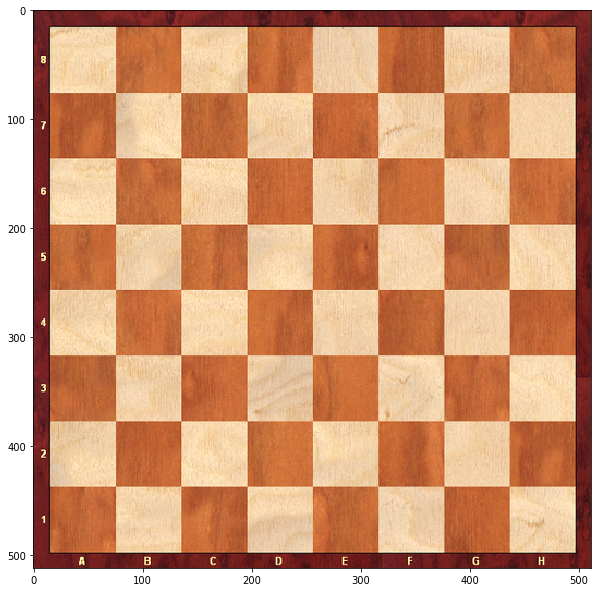

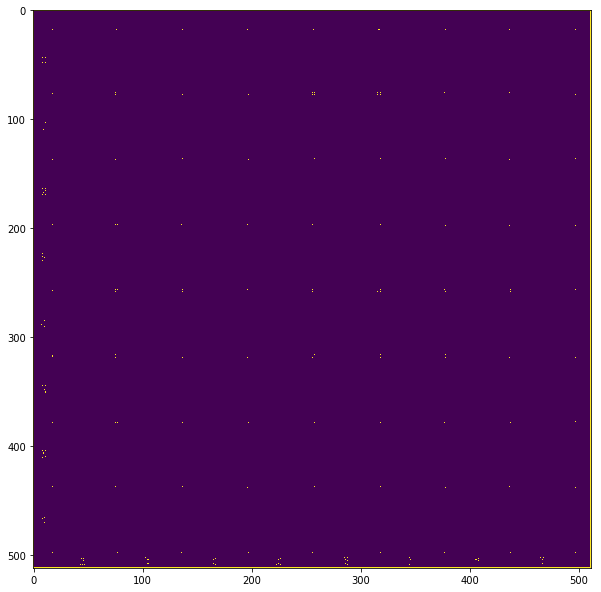

In [71]:
ref = io.imread('images/reference.png')

res = harrisCorner(ref)

plt.figure(1, figsize=(10, 15))
plt.imshow(ref)

plt.figure(2, figsize=(10, 15))
plt.imshow(res)

